<img src="Local\imgs\U1\banner_fcd.jpg" alt="banner" width="1100"  height="150">

# <span style="color:black;"><strong>Detección de Atípicos</strong></span>  
---
<p align="right">
  <a href="https://colab.research.google.com/github/mariabda2/intro_data_2025/blob/main/FCD_U3_deteccion_atipicos.ipynb?clone=true" target="_blank">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Abrir en Colab"/>
  </a>
</p>

## <span style="color:#2F749F;"><strong>🎯 Objetivos de aprendizaje</strong></span>

> ✅ Comprender el concepto de **dato atípico** y su importancia en el análisis estadístico y en proyectos de ciencia de datos.  
>  
> ✅ Identificar y aplicar diferentes **técnicas de detección de atípicos** en datos univariados y multivariados (gráficas, métodos estadísticos y enfoques basados en modelos).  
>  
> ✅ Analizar el impacto de los atípicos en la **calidad de los modelos predictivos y descriptivos**, evaluando riesgos y sesgos asociados.  
>  
> ✅ Desarrollar criterios para decidir **cuándo corregir, transformar o conservar los datos atípicos**, según el contexto y los objetivos del análisis.  
>  
> ✅ Implementar métodos de detección de atípicos en **ejercicios prácticos con Python**, fortaleciendo la capacidad de limpiar y preparar datos de forma crítica.  


In [5]:
# Importar librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor


# <span style="color:#2F749F;"><strong>1. Introducción</strong></span>

Un **dato atípico (outlier)** es una observación que se aleja significativamente de la tendencia general de los datos.  
Estos pueden deberse a ([Barnett & Lewis, 1994](https://onlinelibrary.wiley.com/doi/book/10.1002/9781118499685)):
- **Errores de medición**: problemas de captura de datos.  
- **Variabilidad natural**: casos raros pero posibles.  
- **Eventos excepcionales**: casos anómalos que aportan valor al análisis.  

**Tipos de atípicos**:
1. Univariados: observaciones extremas en una sola variable.  
2. Multivariados: puntos que, aunque no extremos en una variable, lo son considerando varias a la vez.  
3. Globales: muy distintos al resto de los datos.  
4. Locales: difieren de su vecindario inmediato pero no del conjunto completo.  

<div style="background-color:#fff9db; padding:20px; border-radius:10px; font-size:20px;">
  <b>¿Posible fuente?</b><br>
</div>


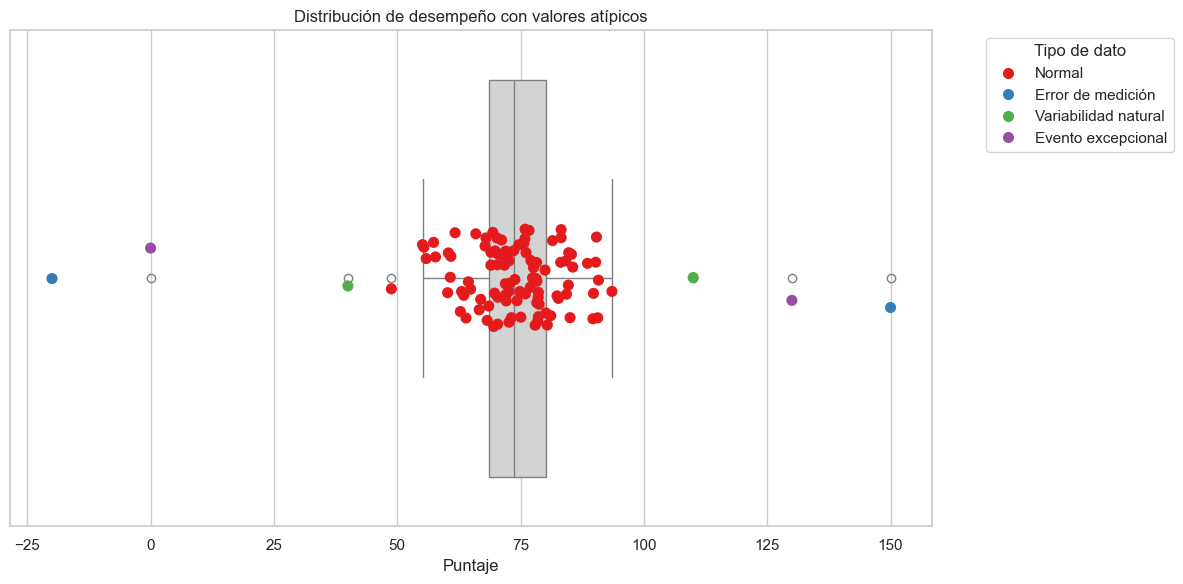

In [ ]:

# Configuración estética
sns.set(style="whitegrid")
np.random.seed(42)

# Datos base: desempeño normal (variabilidad natural)
n = 100
desempeño_normal = np.random.normal(loc=75, scale=10, size=n)

# Error de medición: valores imposibles o mal capturados
errores_medicion = np.array([150, -20])  # fuera de rango lógico

# Variabilidad natural: casos raros pero posibles
casos_raros = np.array([40, 110])  # extremos pero plausibles

#Eventos excepcionales: logros sobresalientes o fallos críticos
eventos_excepcionales = np.array([0, 130])  # anómalos con valor analítico

# Combinar todo
datos = np.concatenate([desempeño_normal, errores_medicion, casos_raros, eventos_excepcionales])
df = pd.DataFrame({'Desempeño': datos})

# Clasificación para visualización
df['Tipo'] = 'Normal'
df.loc[df['Desempeño'].isin(errores_medicion), 'Tipo'] = 'Error de medición'
df.loc[df['Desempeño'].isin(casos_raros), 'Tipo'] = 'Variabilidad natural'
df.loc[df['Desempeño'].isin(eventos_excepcionales), 'Tipo'] = 'Evento excepcional'

plt.figure(figsize=(12, 6))
sns.boxplot(x='Desempeño', data=df, color='lightgray')
sns.stripplot(x='Desempeño', data=df, hue='Tipo', jitter=True, size=8, palette='Set1', dodge=False)
plt.title('Distribución de desempeño con valores atípicos')
plt.xlabel('Puntaje')
plt.legend(title='Tipo de dato', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<div style="background-color:#fff9db; padding:20px; border-radius:10px;font-size:20px;">
  <b>Tipos de datos atípicos</b><br>
</div>

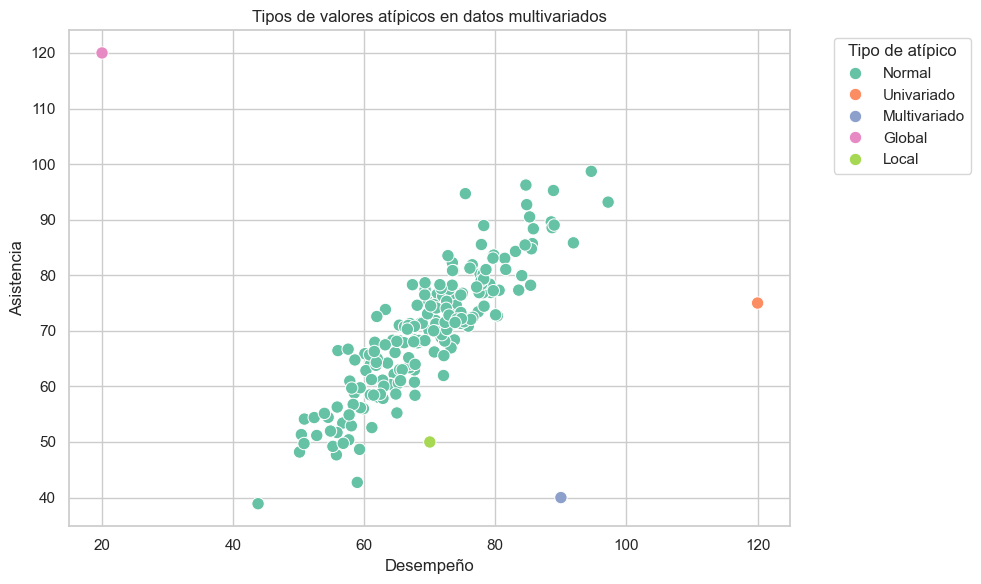

In [13]:
# Configuración estética
sns.set_theme(style="whitegrid")
np.random.seed(42)

# Datos base: dos variables correlacionadas (por ejemplo, desempeño y asistencia)
n = 200
x1 = np.random.normal(loc=70, scale=10, size=n)
x2 = x1 + np.random.normal(loc=0, scale=5, size=n)  # correlación positiva

# Datos 
df_base = pd.DataFrame({
    'Desempeño': x1,
    'Asistencia': x2,
    'Tipo': ['Normal'] * n
})

# Atípicos 
df_outliers = pd.DataFrame({
    'Desempeño': [120, 90, 20, 70],
    'Asistencia': [75, 40, 120, 50],
    'Tipo': ['Univariado', 'Multivariado', 'Global', 'Local']
})

# Combinar
df = pd.concat([df_base, df_outliers], ignore_index=True)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Desempeño', y='Asistencia', hue='Tipo', palette='Set2', s=80)
plt.title('Tipos de valores atípicos en datos multivariados')
plt.xlabel('Desempeño')
plt.ylabel('Asistencia')
plt.legend(title='Tipo de atípico', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# <span style="color:#2F749F;"><strong>2. Detección de patrones o tendencias</strong></span>  

La detección de anomalías no se restringe únicamente a valores atípicos individuales, sino que también busca **patrones o tendencias** que puedan revelar comportamientos inusuales o desviaciones significativas respecto al comportamiento esperado. Este enfoque es clave en análisis exploratorio, control de calidad, seguridad informática y detección de fraudes.  

Entre las principales técnicas se encuentran:  

- **Gráficas de dispersión**  
  Permiten identificar puntos que se alejan de la tendencia general.  
  - *Ejemplo*: En un análisis de altura vs. peso, un punto ubicado muy lejos de la nube principal podría representar un **error de medición** o un **caso médico especial**.  


- **Histogramas y funciones de densidad**  
  Muestran concentraciones, colas largas o distribuciones multimodales.  
  - *Ejemplo*: En tiempos de respuesta de un servidor web, una **cola larga a la derecha** puede indicar casos de **congestión o ataques DDoS**.


- **Métodos estadísticos clásicos**  
  - **Z-score**: mide la desviación estándar de un punto respecto a la media.  
    - *Ejemplo*: En calificaciones de un examen (promedio 3.5, σ=0.5), un estudiante con nota **5.0** tendrá un **Z-score alto**, indicando desempeño muy atípico.  
  - **IQR (rango intercuartílico)**: detecta valores alejados de la dispersión central.  
    - *Ejemplo*: En salarios, si el rango central está entre 1.5M y 3M, un salario de **15M** será marcado como **outlier extremo**.


- **Modelos de aprendizaje no supervisado**  
  - **Clustering (DBSCAN, k-means, etc.)**:  
    - *Ejemplo*: En datos de clientes, DBSCAN puede detectar un pequeño grupo con **patrones de compra inusuales** (fraudes o compradores VIP).  
  - **Métodos de densidad y proximidad (LOF, k-NN)**:  
    - *Ejemplo*: En ciberseguridad, un host con tráfico muy distinto a sus vecinos inmediatos puede representar un **ataque o intrusión**.  


En la literatura, estos enfoques han sido ampliamente documentados y clasificados en taxonomías de detección de anomalías (ver [Chandola, Banerjee, & Kumar, 2009](https://dl.acm.org/doi/10.1145/1541880.1541882)).  


<div style="background-color:#fff9db; padding:20px; border-radius:10px;font-size:20px;">
  <b>Gráficas de dispersión</b><br>
</div>

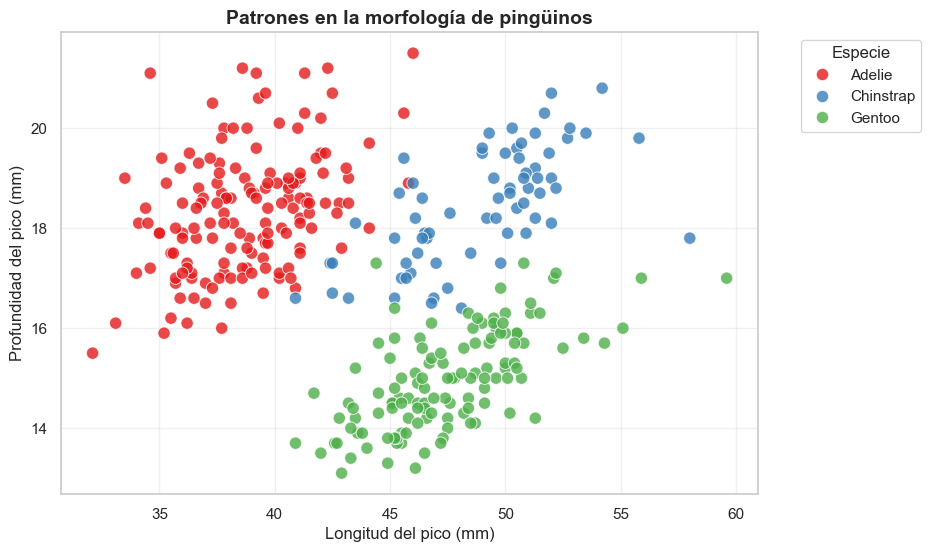

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar dataset
penguins = sns.load_dataset("penguins").dropna(subset=["bill_length_mm", "bill_depth_mm"])

# Crear gráfica de dispersión
plt.figure(figsize=(9, 6))
sns.scatterplot(
    data=penguins,
    x="bill_length_mm",
    y="bill_depth_mm",
    hue="species",   # Colorear por especie
    s=80,
    alpha=0.8,
    palette="Set1"
)

# Títulos y estilo
plt.title("Patrones en la morfología de pingüinos", fontsize=14, weight="bold")
plt.xlabel("Longitud del pico (mm)")
plt.ylabel("Profundidad del pico (mm)")
plt.legend(title="Especie", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(alpha=0.3)
plt.show()


<div style="background-color:#fff9db; padding:20px; border-radius:10px;font-size:20px;">
  <b>Histogramas y funciones de densidad</b><br>
</div> 

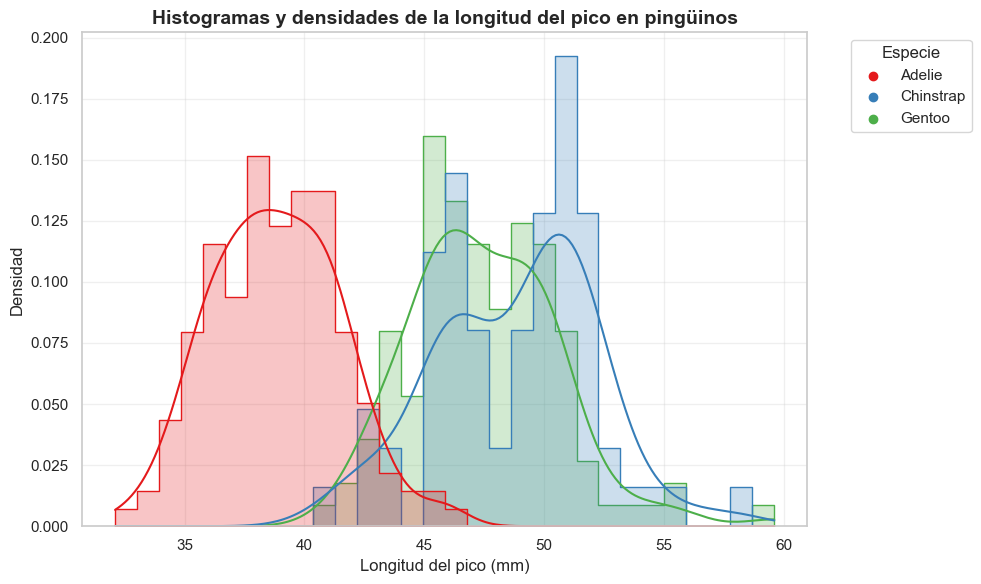

In [38]:
# Cargar dataset
penguins = sns.load_dataset("penguins").dropna(subset=["bill_length_mm"])
species = penguins["species"].unique()
palette = dict(zip(species, sns.color_palette("Set1", n_colors=len(species))))

# Crear figura
plt.figure(figsize=(10, 6))

# Histograma 
ax = sns.histplot(
    data=penguins,
    x="bill_length_mm",
    hue="species",
    kde=True,
    bins=30,
    element="step",
    stat="density",
    common_norm=False,
    palette=palette,
    legend=False  
)

plt.title("Histogramas y densidades de la longitud del pico en pingüinos", fontsize=14, weight="bold")
plt.xlabel("Longitud del pico (mm)")
plt.ylabel("Densidad")

for sp in species:
    ax.scatter([], [], color=palette[sp], label=sp)

ax.legend(title="Especie", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


<div style="background-color:#fff9db; padding:20px; border-radius:10px;font-size:20px;">
  <b>Métodos estadísticos clásicos</b><br>
</div> 

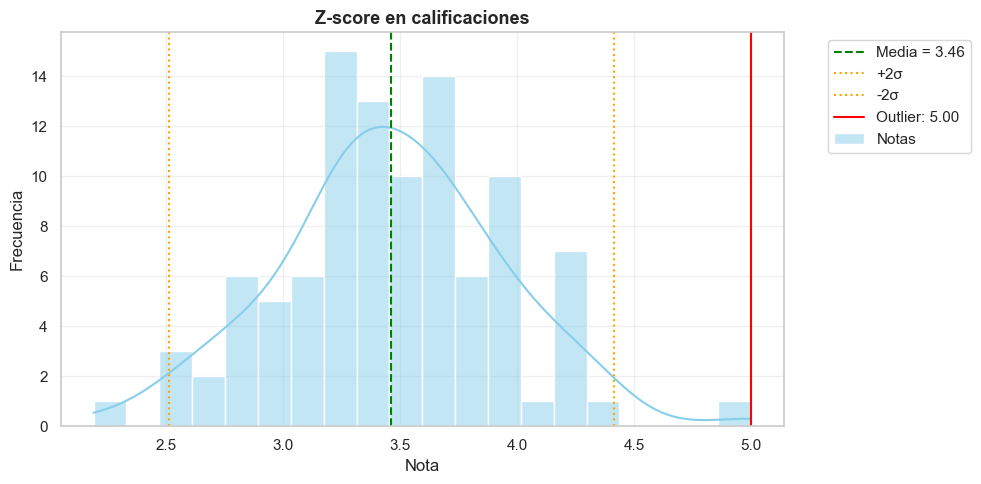

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Datos simulados (notas)
np.random.seed(42)
notas = np.random.normal(loc=3.5, scale=0.5, size=100)
notas = np.append(notas, 5.0)  # estudiante atípico

# Cálculo de Z-score
z_scores = stats.zscore(notas)
outliers_z = notas[np.abs(z_scores) > 3]

# Visualización

plt.figure(figsize=(10, 5))
sns.histplot(notas, bins=20, kde=True, color="skyblue", label="Notas")
plt.axvline(np.mean(notas), color="green", linestyle="--", label=f"Media = {np.mean(notas):.2f}")
plt.axvline(np.mean(notas) + 2*np.std(notas), color="orange", linestyle=":", label="+2σ")
plt.axvline(np.mean(notas) - 2*np.std(notas), color="orange", linestyle=":", label="-2σ")

for out in outliers_z:
    plt.axvline(out, color="red", linestyle="-", label=f"Outlier: {out:.2f}")

plt.title("Z-score en calificaciones", fontsize=13, weight="bold")
plt.xlabel("Nota")
plt.ylabel("Frecuencia")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


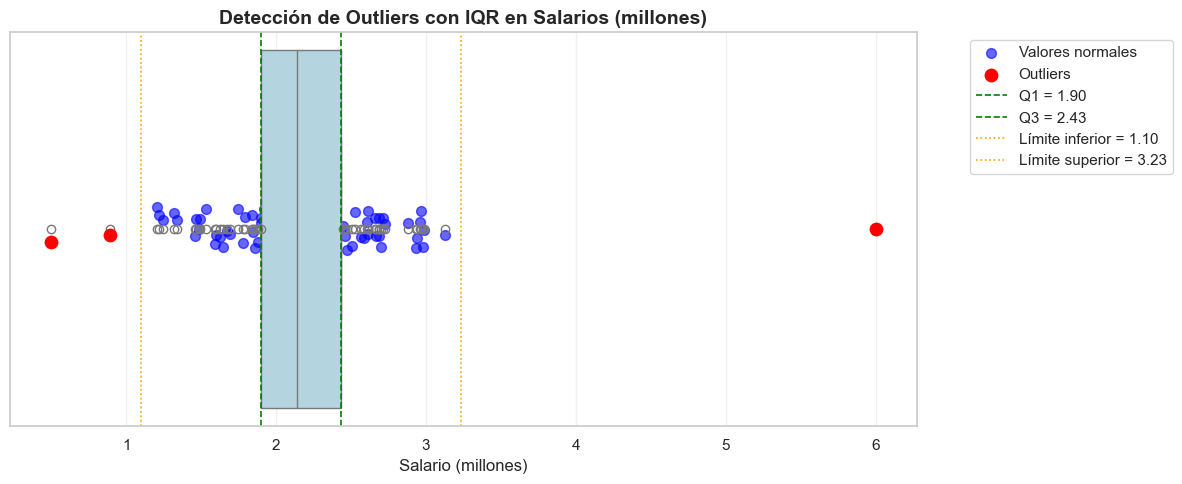

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Datos simulados (salarios en millones)
np.random.seed(42)
salarios = np.random.normal(loc=2.2, scale=0.5, size=100)
salarios = np.append(salarios, [0.5, 6.0])  # outliers en ambos extremos

# Cálculo de IQR
Q1, Q3 = np.percentile(salarios, [25, 75])
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers_iqr = salarios[(salarios < limite_inferior) | (salarios > limite_superior)]
normales_iqr = salarios[(salarios >= limite_inferior) & (salarios <= limite_superior)]


# Visualización
plt.figure(figsize=(12, 5))

sns.boxplot(x=salarios, color="lightblue", width=0.3)
plt.scatter(normales_iqr, np.random.uniform(-0.05, 0.05, size=len(normales_iqr)),
            color="blue", s=50, alpha=0.6, label="Valores normales")
plt.scatter(outliers_iqr, np.random.uniform(-0.05, 0.05, size=len(outliers_iqr)),
            color="red", s=80, zorder=5, label="Outliers")
plt.axvline(Q1, color="green", linestyle="--", linewidth=1.2, label=f"Q1 = {Q1:.2f}")
plt.axvline(Q3, color="green", linestyle="--", linewidth=1.2, label=f"Q3 = {Q3:.2f}")
plt.axvline(limite_inferior, color="orange", linestyle=":", linewidth=1.2, label=f"Límite inferior = {limite_inferior:.2f}")
plt.axvline(limite_superior, color="orange", linestyle=":", linewidth=1.2, label=f"Límite superior = {limite_superior:.2f}")

plt.title("Detección de Outliers con IQR en Salarios (millones)", fontsize=14, weight="bold")
plt.xlabel("Salario (millones)")
plt.yticks([])  # quitar eje Y porque no aporta
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(alpha=0.3, axis="x")
plt.tight_layout()
plt.show()


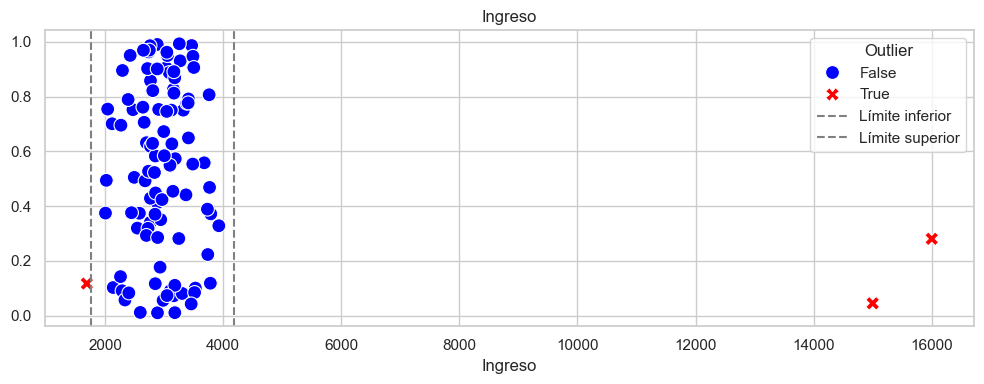

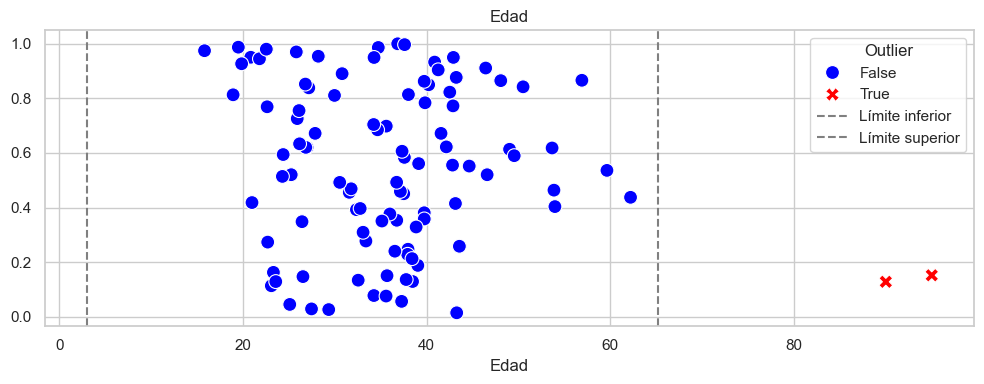

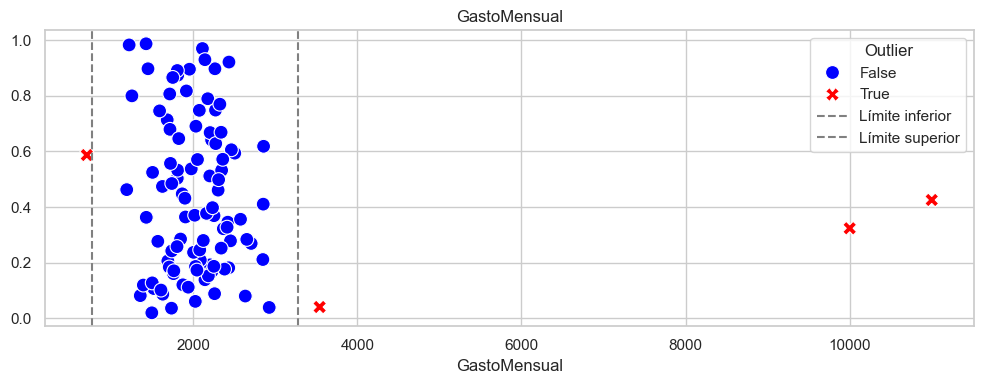

In [68]:
# Datos
np.random.seed(42)
n = 100

df = pd.DataFrame({
    'Ingreso': np.append(np.random.normal(3000, 500, n), [15000, 16000]),
    'Edad': np.append(np.random.normal(35, 10, n), [90, 95]),
    'GastoMensual': np.append(np.random.normal(2000, 400, n), [10000, 11000])
})

for col in df.columns:
    # Calcular IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.7 * IQR
    lim_sup = Q3 + 1.7 * IQR

    # Detectar outliers
    df['Outlier'] = (df[col] < lim_inf) | (df[col] > lim_sup)

    df['y'] = np.random.uniform(0, 1, size=len(df))

    # Gráfica
    plt.figure(figsize=(10, 4))
    sns.scatterplot(
        data=df,
        x=col,
        y='y',
        hue='Outlier',
        palette={True: 'red', False: 'blue'},
        style='Outlier',
        markers={True: 'X', False: 'o'},
        s=100
    )

    plt.axvline(lim_inf, linestyle='--', color='gray', label='Límite inferior')
    plt.axvline(lim_sup, linestyle='--', color='gray', label='Límite superior')

    plt.title(f'{col}')
    plt.xlabel(col)
    plt.ylabel("")
    plt.legend(title='Outlier')
    plt.tight_layout()
    plt.show()


<div style="background-color:#fff9db; padding:20px; border-radius:10px;font-size:20px;">
  <b>Modelos de aprendizaje no supervisado</b><br>
</div> 

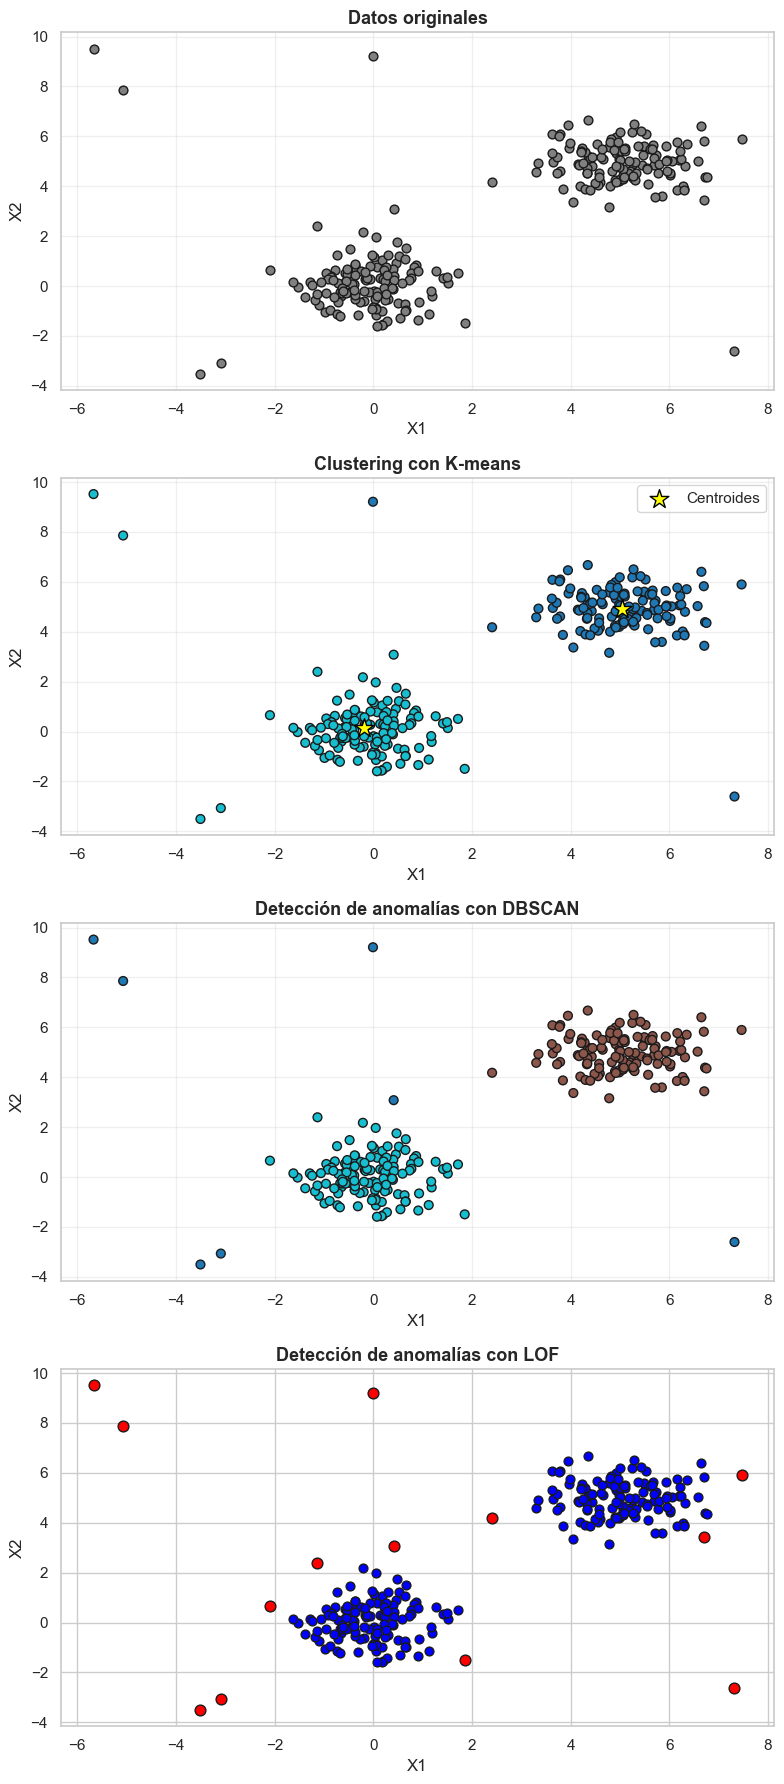

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import LocalOutlierFactor

# Dataset simulado
np.random.seed(42)
X, _ = make_blobs(n_samples=250, centers=[(0,0), (5,5)], cluster_std=0.8, random_state=42)

# Agregar outliers artificiales
outliers = np.random.uniform(low=-6, high=10, size=(10, 2))
X = np.vstack([X, outliers])

# K-means
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X)

# DBSCAN
dbscan = DBSCAN(eps=1.0, min_samples=5)
labels_dbscan = dbscan.fit_predict(X)

# LOF (Local Outlier Factor)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
labels_lof = lof.fit_predict(X)

# Visualización (4 filas)
fig, axes = plt.subplots(4, 1, figsize=(8, 18))

# ---- Datos originales
axes[0].scatter(X[:, 0], X[:, 1], c="gray", s=40, edgecolor="k")
axes[0].set_title("Datos originales", fontsize=13, weight="bold")
axes[0].set_xlabel("X1"); axes[0].set_ylabel("X2"); axes[0].grid(alpha=0.3)

# ---- K-means
axes[1].scatter(X[:, 0], X[:, 1], c=labels_kmeans, cmap="tab10", s=40, edgecolor="k")
axes[1].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                c="yellow", s=200, edgecolor="black", marker="*",
                label="Centroides")
axes[1].set_title("Clustering con K-means", fontsize=13, weight="bold")
axes[1].set_xlabel("X1"); axes[1].set_ylabel("X2"); axes[1].legend(); axes[1].grid(alpha=0.3)

# ---- DBSCAN
axes[2].scatter(X[:, 0], X[:, 1], c=labels_dbscan, cmap="tab10", s=40, edgecolor="k")
axes[2].set_title("Detección de anomalías con DBSCAN", fontsize=13, weight="bold")
axes[2].set_xlabel("X1"); axes[2].set_ylabel("X2"); axes[2].grid(alpha=0.3)

# ---- LOF
axes[3].scatter(X[labels_lof == 1, 0], X[labels_lof == 1, 1],
                c="blue", s=40, label="Normal", edgecolor="k")
axes[3].scatter(X[labels_lof == -1, 0], X[labels_lof == -1, 1],
                c="red", s=60, label="Outlier", edgecolor="k")
axes[3].set_title("Detección de anomalías con LOF", fontsize=13, weight="bold")
axes[3].set_xlabel("X1"); axes[3].set_ylabel("X2")

plt.tight_layout()
plt.show()


# <span style="color:#2F749F;"><strong>3. Generación de hipótesis</strong></span>  

La presencia de **valores atípicos** no solo representa un reto técnico en el análisis de datos, sino también una **oportunidad para la investigación científica**. Los atípicos pueden convertirse en señales valiosas que motivan la formulación de nuevas hipótesis, abriendo caminos de exploración más allá de la simple depuración de datos.  

Algunas preguntas clave que orientan este proceso son:  

- ¿El atípico corresponde a un **error de captura, medición o procesamiento** de datos?  
  - *Ejemplo*: En un dataset de estaturas, aparece un valor de **3.5 metros**; probablemente se deba a un error de digitación (350 cm en lugar de 1.75 m).  
- ¿Representa un **subgrupo especial o minoritario** dentro de la población estudiada?  
  - *Ejemplo*: En un análisis de gastos familiares, un grupo pequeño muestra consumos muy altos en tecnología; podrían ser **early adopters** o familias con perfiles profesionales específicos.  
- ¿Sugiere la existencia de un **fenómeno emergente, desconocido o no contemplado** en la teoría actual?  
  - *Ejemplo*: En registros médicos, se observa un conjunto de pacientes jóvenes con síntomas inusuales; este patrón podría anticipar la identificación de una **nueva enfermedad o variante**.  
- ¿Debe **eliminarse, corregirse o conservarse**, dependiendo del contexto del análisis y de los objetivos de la investigación?  
  - *Ejemplo*: En un estudio de clima, una temperatura de **48°C en una ciudad costera** puede ser un error de sensor o, por el contrario, una señal del **cambio climático** que merece investigarse.  

En este sentido, el análisis de valores atípicos no debe entenderse únicamente como una tarea de limpieza, sino como un **insumo clave para la generación de hipótesis y toma de decisiones**. Esta reflexión permite determinar si los datos anómalos aportan conocimiento adicional, evidencian fallas en la calidad de los datos o muestran dinámicas estructurales en el fenómeno estudiado.  

👉 La literatura enfatiza que el manejo de anomalías constituye una fase crítica y contextual en ciencia de datos, pues puede guiar tanto la validación como la creación de teorías (ver [Aggarwal, 2017](https://link.springer.com/book/10.1007/978-3-319-47578-3)).  


---

<div style="text-align:center; color:#607D8B; font-weight:bold; font-size:14px;">
“Sin datos, solo eres otra persona con una opinión.” – W. Edwards Deming
</div>